# Facial expression recognition using CNN

## Imports

In [1]:
# Standard library imports
import os
import warnings

# Related third-party imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras imports
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.src.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.src.regularizers import l2

## Dataset

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
# Directory variables
root_dir = 'data/'
train_dir = root_dir + 'train/'
test_dir = root_dir + 'test/'

In [4]:
# Extract target variables from directory names
target_var = os.listdir(train_dir)
target_var.remove('.DS_Store')
target_var

['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

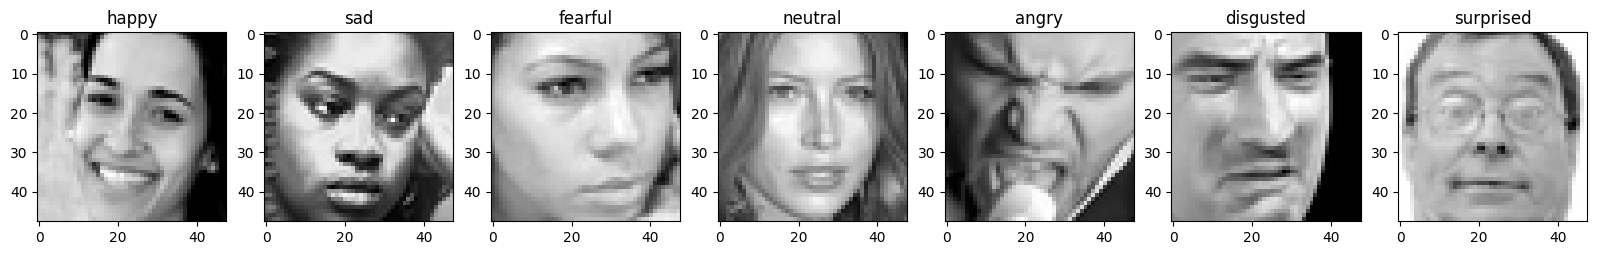

In [5]:
# Display sample images from each category
fig, axes = plt.subplots(1, 7, figsize=(20, 8))
for i in range(len(target_var)):
    d = train_dir + target_var[i] + '/' + os.listdir(train_dir + target_var[i] + '/')[0]
    axes[i].imshow(plt.imread(d), cmap='gray')
    axes[i].set_title(target_var[i])
plt.show()

### Exploratory data analysis

In [6]:
# Number of images in each class
x_train = np.array([len(os.listdir(train_dir + i + '/')) for i in target_var])
x_test = np.array([len(os.listdir(test_dir + i + '/')) for i in target_var])

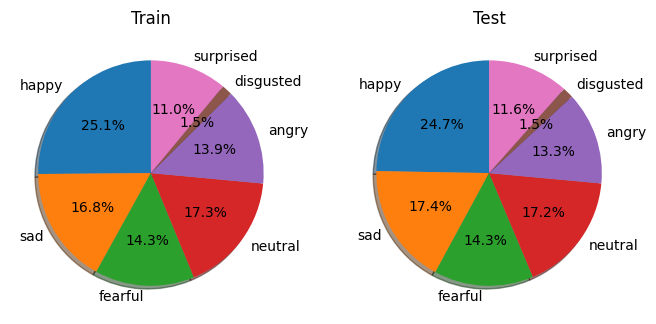

In [7]:
# Pie charts for visualizing train and test data distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].pie(x_train, labels=target_var, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].pie(x_test, labels=target_var, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

### Data loading and preprocessing

In [8]:
# Image Data Generators for training and testing
train_idg = ImageDataGenerator(
    rescale=1. / 255, 
    validation_split=0.3, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_idg = ImageDataGenerator(rescale=1. / 255)

In [9]:
# Parameters for data generation
img_size = (48, 48)
batch_size = 64
arg_train = {
    'target_size': img_size, 
    'color_mode': 'grayscale', 
    'class_mode': 'categorical', 
    'batch_size': batch_size,
    'shuffle': True
}
arg_test = {
    'target_size': img_size, 
    'color_mode': 'grayscale', 
    'class_mode': 'categorical', 
    'batch_size': batch_size, 
    'shuffle': False
}

train = train_idg.flow_from_directory(directory=train_dir, subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=train_dir, subset='validation', **arg_train)
test = test_idg.flow_from_directory(directory=test_dir, **arg_test)

Found 20099 images belonging to 7 classes.
Found 8611 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
class_indices = train.class_indices
class_labels = list(class_indices.keys())
# Sorting the class labels based on their corresponding indices
class_labels.sort(key=lambda label: class_indices[label])
class_labels

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

## Convolutional neural network

### Model definition

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(48, 48, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.summary()

2023-11-24 22:08:55.975004: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-24 22:08:55.975026: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-24 22:08:55.975035: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-24 22:08:55.975107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-24 22:08:55.975137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                       

### Model training

In [12]:
# Compile and fit model
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=0.00001, 
    verbose=1
)
model.compile(
    optimizer=Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics='accuracy'
)
history = model.fit(
    train, 
    validation_data=valid, 
    epochs=100, 
    callbacks=[reduce_lr]
)

Epoch 1/100


2023-11-24 22:08:57.047720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


315/315 [==============================] - 29s 87ms/step - loss: 4.5280 - accuracy: 0.1926 - val_loss: 3.7464 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 2/100
315/315 [==============================] - 27s 87ms/step - loss: 3.3899 - accuracy: 0.2279 - val_loss: 2.9022 - val_accuracy: 0.2527 - lr: 0.0010
Epoch 3/100
315/315 [==============================] - 28s 88ms/step - loss: 2.6773 - accuracy: 0.2371 - val_loss: 2.3920 - val_accuracy: 0.2475 - lr: 0.0010
Epoch 4/100
315/315 [==============================] - 28s 89ms/step - loss: 2.2238 - accuracy: 0.2682 - val_loss: 2.0276 - val_accuracy: 0.2958 - lr: 0.0010
Epoch 5/100
315/315 [==============================] - 27s 87ms/step - loss: 1.9613 - accuracy: 0.3089 - val_loss: 1.8481 - val_accuracy: 0.3396 - lr: 0.0010
Epoch 6/100
315/315 [==============================] - 28s 88ms/step - loss: 1.8264 - accuracy: 0.3357 - val_loss: 1.7794 - val_accuracy: 0.3513 - lr: 0.0010
Epoch 7/100
315/315 [==============================] - 28s 88ms/

### Model evaluation

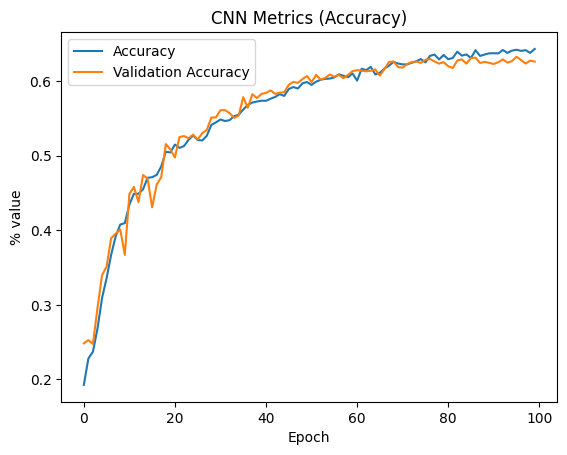

In [13]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

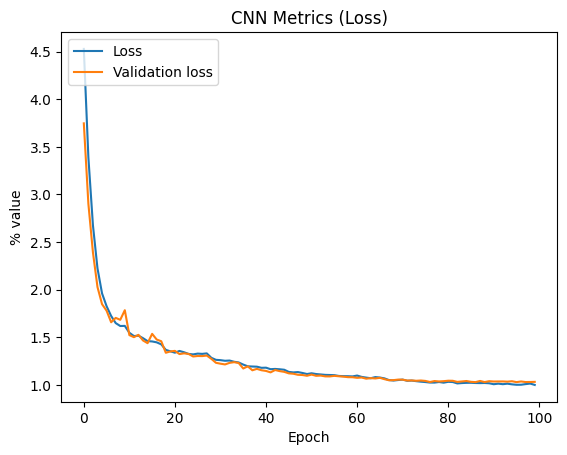

In [14]:
# Plot training loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('CNN Metrics (Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [15]:
# Model Evaluation
y_pred = model.predict(test)
y_pred_labels = [np.argmax(i) for i in y_pred]
y_actual = test.classes[test.index_array]

113/113 [==============================] - 2s 14ms/step


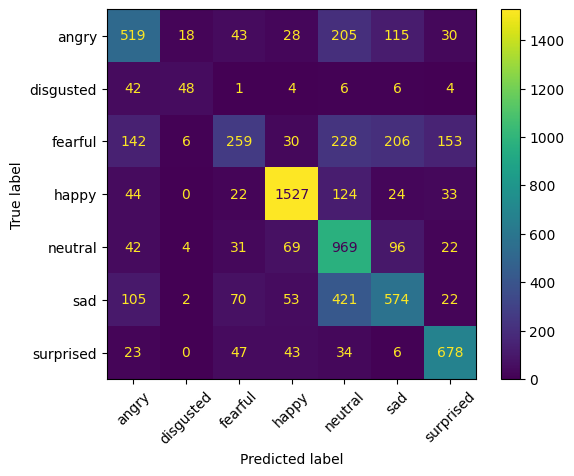

In [16]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_actual, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.xticks(rotation=45)
plt.show()

In [17]:
# Classification Report
print(classification_report(y_actual, y_pred_labels, digits=4, target_names=class_labels))

              precision    recall  f1-score   support

       angry     0.5660    0.5418    0.5536       958
   disgusted     0.6154    0.4324    0.5079       111
     fearful     0.5476    0.2529    0.3460      1024
       happy     0.8706    0.8608    0.8656      1774
     neutral     0.4877    0.7859    0.6019      1233
         sad     0.5589    0.4603    0.5048      1247
   surprised     0.7197    0.8159    0.7648       831

    accuracy                         0.6372      7178
   macro avg     0.6237    0.5929    0.5921      7178
weighted avg     0.6425    0.6372    0.6247      7178



### Model saving

In [18]:
model.save('cnn.h5')